<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/025_CHGNET_Proj_TwentyFive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs

In [ ]:
!pip install requests==2.31.0

In [ ]:
!pip install -q pymatgen

In [ ]:
!pip install -q --upgrade git+https://gitlab.com/ase/ase.git@master

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q crystal-toolkit

In [ ]:
!pip install -q dash

In [ ]:
!pip install -q matgl

In [ ]:
!pip install -q phonopy

In [ ]:
!pip install -q seekpath

In [ ]:
try:
    import chgnet
except ImportError:
    !pip install -q chgnet

In [ ]:
%%capture
!pip install git+https://github.com/materialsproject/atomate2.git@main

In [ ]:
!pip install -q jobflow

In [ ]:
# utils
from __future__ import print_function, division
import os, sys, functools, shutil
import time, warnings
import csv, json, pickle
import random
import numpy as np
import pandas as pd
from jobflow import run_locally, SETTINGS as JFSet
# url
from urllib.request import urlopen
# google
from google.colab import drive
# sklearn
from sklearn import metrics
# pymatgen
from pymatgen.core.structure import Structure
from pymatgen.entries.compatibility import MaterialsProject2020Compatibility
from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.phonon.bandstructure import PhononBandStructureSymmLine
from pymatgen.phonon.dos import PhononDos
from pymatgen.phonon.plotter import PhononBSPlotter, PhononDosPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from atomate2.forcefields.flows.elastic import ElasticMaker
from atomate2.forcefields.jobs import M3GNetRelaxMaker
# ase
from ase.io import read
# atomate
from atomate2.forcefields.flows.phonons import PhononMaker
from atomate2.forcefields.jobs import M3GNetRelaxMaker, M3GNetStaticMaker
# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
# chgnet
from chgnet import ROOT
from chgnet.model import CHGNet, StructOptimizer
from chgnet.model.dynamics import MolecularDynamics
from chgnet.model.composition_model import AtomRef
from chgnet.graph import CrystalGraphConverter
from chgnet.data.dataset import StructureData, get_train_val_test_loader
from chgnet.trainer import Trainer
from chgnet.utils import write_json
# from chgnet.utils import parse_vasp_dir # returns error
# crystal_toolkit
# import crystal_toolkit.components as ctc # returns error
from crystal_toolkit.settings import SETTINGS
# dash
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
# vis
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive') # mount google drive

Mounted at /content/drive


In [ ]:
working_dir = '/content/drive/MyDrive/DataSets'
os.chdir(working_dir)
assert os.getcwd() == working_dir

# Basics

## Understand Data

In [ ]:
try:
  structure = Structure.from_file(f"{ROOT}/examples/mp-18767-LiMnO2.cif")
except Exception:
  from urllib.request import urlopen
  url = "https://raw.githubusercontent.com/CederGroupHub/chgnet/main/examples/mp-18767-LiMnO2.cif"
  cif = urlopen(url).read().decode("utf-8")
  structure = Structure.from_str(cif, fmt="cif")
print(structure)

Full Formula (Li2 Mn2 O4)
Reduced Formula: LiMnO2
abc   :   2.868779   4.634475   5.832507
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP      a    b         c
---  ----  ---  ---  --------
  0  Li+   0.5  0.5  0.37975
  1  Li+   0    0    0.62025
  2  Mn3+  0.5  0.5  0.863252
  3  Mn3+  0    0    0.136747
  4  O2-   0.5  0    0.360824
  5  O2-   0    0.5  0.098514
  6  O2-   0.5  0    0.901486
  7  O2-   0    0.5  0.639176


## Model Predict of Energy, Force, Stress and Magmom

In [ ]:
chgnet = CHGNet.load()
# chgnet = CHGNet.from_file(model_path)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu


In [ ]:
chgnet

CHGNet(
  (composition_model): AtomRef(
    (fc): Linear(in_features=94, out_features=1, bias=False)
  )
  (graph_converter): CrystalGraphConverter(algorithm='fast', atom_graph_cutoff=6, bond_graph_cutoff=3)
  (atom_embedding): AtomEmbedding(
    (embedding): Embedding(94, 64)
  )
  (bond_basis_expansion): BondEncoder(
    (rbf_expansion_ag): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
    (rbf_expansion_bg): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
  )
  (bond_embedding): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_ag): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_bg): Linear(in_features=31, out_features=64, bias=False)
  (angle_basis_expansion): AngleEncoder(
    (fourier_expansion): Fourier()
  )
  (angle_embedding): Linear(in_features=31, out_features=64, bias=False)
  (atom_conv_layers): ModuleList(
    (0-3): 4 x AtomConv(
      (activation): SiLU()
      (twoBody_atom): GatedMLP(
        (mlp_c

In [ ]:
list(chgnet.children())

[AtomRef(
   (fc): Linear(in_features=94, out_features=1, bias=False)
 ),
 CrystalGraphConverter(algorithm='fast', atom_graph_cutoff=6, bond_graph_cutoff=3),
 AtomEmbedding(
   (embedding): Embedding(94, 64)
 ),
 BondEncoder(
   (rbf_expansion_ag): RadialBessel(
     (smooth_cutoff): CutoffPolynomial()
   )
   (rbf_expansion_bg): RadialBessel(
     (smooth_cutoff): CutoffPolynomial()
   )
 ),
 Linear(in_features=31, out_features=64, bias=False),
 Linear(in_features=31, out_features=64, bias=False),
 Linear(in_features=31, out_features=64, bias=False),
 AngleEncoder(
   (fourier_expansion): Fourier()
 ),
 Linear(in_features=31, out_features=64, bias=False),
 ModuleList(
   (0-3): 4 x AtomConv(
     (activation): SiLU()
     (twoBody_atom): GatedMLP(
       (mlp_core): MLP(
         (layers): Sequential(
           (0): Linear(in_features=192, out_features=64, bias=True)
           (1): SiLU()
           (2): Dropout(p=0, inplace=False)
           (3): Linear(in_features=64, out_features

In [ ]:
prediction = chgnet.predict_structure(structure)
for key, unit in [
    ("energy", "eV/atom"),
    ("forces", "eV/A"),
    ("stress", "GPa"),
    ("magmom", "mu_B"),
    ]:
    print(f"CHGNet-predicted {key} ({unit}):\n{prediction[key[0]]}\n")

CHGNet-predicted energy (eV/atom):
-7.340123653411865

CHGNet-predicted forces (eV/A):
[[-0.04293664 -0.02978614 -0.22685434]
 [-0.08784267 -0.08406013  0.18419611]
 [-1.105804    0.5264675   0.86177063]
 [ 0.09648013 -0.4459046  -1.4921265 ]
 [ 0.03801006 -0.12903799  0.43026733]
 [ 0.45403957 -0.2258324  -0.26153243]
 [-0.12351727  0.43899187  0.8147239 ]
 [ 0.77157104 -0.05083788 -0.31044382]]

CHGNet-predicted stress (GPa):
[[-1.5445096  -0.06415848  0.42967317]
 [-0.064158    1.5260851   1.0443631 ]
 [ 0.42967778  1.0443634   0.21450236]]

CHGNet-predicted magmom (mu_B):
[3.2862574e-03 2.9201210e-03 3.8372707e+00 3.9001379e+00 3.2951847e-02
 4.7907040e-02 6.1325356e-02 3.2906741e-02]



## Structure Optimization

In [ ]:
relaxer = StructOptimizer()
structure.perturb(0.1)
result = relaxer.relax(structure, verbose=True)
print("Relaxed structure:\n")
print(result["final_structure"])

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu
      Step     Time          Energy          fmax
FIRE:    0 16:14:16      -58.720989        1.560314
FIRE:    1 16:14:17      -58.781406        1.182815
FIRE:    2 16:14:17      -58.852093        0.712389
FIRE:    3 16:14:17      -58.889912        0.433596
FIRE:    4 16:14:18      -58.892323        0.828314
FIRE:    5 16:14:18      -58.895958        0.772439
FIRE:    6 16:14:19      -58.902355        0.662479
FIRE:    7 16:14:19      -58.910015        0.502124
FIRE:    8 16:14:19      -58.917030        0.300984
FIRE:    9 16:14:20      -58.921989        0.194035
FIRE:   10 16:14:20      -58.924450        0.199374
FIRE:   11 16:14:21      -58.925209        0.275158
FIRE:   12 16:14:21      -58.925346        0.270478
FIRE:   13 16:14:21      -58.925617        0.261289
FIRE:   14 16:14:22      -58.926010        0.247876
FIRE:   15 16:14:22      -58.926506        0.230529
FIRE:   16 16:14:23      -58.927082        0.

## Molecular Dynamics

In [ ]:
md = MolecularDynamics(
    atoms=structure,
    model=chgnet,
    ensemble="nvt",
    temperature=1000,  # in k
    timestep=2,  # in fs
    trajectory="md_out.traj",
    logfile="md_out.log",
    loginterval=100,
    )
md.run(50)  # run a 0.1 ps MD simulation

CHGNet will run on cpu
NVT-Berendsen-MD created


## Magmom Visualization

In [ ]:
supercell = structure.make_supercell([2, 2, 2], in_place=False)
print(supercell.composition)

Li+16 Mn3+16 O2-32


In [ ]:
n_Li = int(supercell.composition["Li+"])
remove_ids = random.sample(list(range(n_Li)), n_Li // 2)
supercell.remove_sites(remove_ids)
print(supercell.composition)

Li+8 Mn3+16 O2-32


In [ ]:
result = relaxer.relax(supercell)

      Step     Time          Energy          fmax
FIRE:    0 16:14:43     -424.299992        2.241214
FIRE:    1 16:14:44     -425.079742        1.897576
FIRE:    2 16:14:46     -426.209221        1.298713
FIRE:    3 16:14:47     -427.019039        0.802441
FIRE:    4 16:14:48     -427.336456        1.061682
FIRE:    5 16:14:49     -427.280060        1.116925
FIRE:    6 16:14:51     -427.331356        1.040043
FIRE:    7 16:14:52     -427.422253        0.908461
FIRE:    8 16:14:53     -427.532722        0.735843
FIRE:    9 16:14:54     -427.640148        0.566146
FIRE:   10 16:14:55     -427.728268        0.471243
FIRE:   11 16:14:56     -427.787521        0.390542
FIRE:   12 16:14:58     -427.819778        0.362161
FIRE:   13 16:15:00     -427.838898        0.450673
FIRE:   14 16:15:01     -427.857243        0.511071
FIRE:   15 16:15:02     -427.887791        0.526382
FIRE:   16 16:15:03     -427.938847        0.489472
FIRE:   17 16:15:04     -428.009369        0.418503
FIRE:   18 16:

In [ ]:
result

{'final_structure': Structure Summary
 Lattice
     abc : 5.787193261540743 8.496929304156444 12.463578571872494
  angles : 90.26840692426829 90.19349629518996 89.99170894889954
  volume : 612.8659608384035
       A : 5.787184566398657 0.00039533550916022946 -0.010024199200492436
       B : 0.0006103839957841055 8.496899857199896 -0.022361663182474765
       C : -0.020501021297269707 -0.0255843722055762 12.463535452080354
     pbc : True True True
 PeriodicSite: Li+ (1.495, 2.246, 2.516) [0.259, 0.2649, 0.2026]
 PeriodicSite: Li+ (1.846, 6.31, 2.662) [0.3196, 0.7433, 0.2151]
 PeriodicSite: Li+ (4.297, 2.325, 9.045) [0.7451, 0.2757, 0.7268]
 PeriodicSite: Li+ (4.298, 6.013, 8.817) [0.7451, 0.7098, 0.7093]
 PeriodicSite: Li+ (-0.1478, -0.134, 3.652) [-0.02451, -0.01489, 0.2929]
 PeriodicSite: Li+ (0.005853, 0.04572, 9.909) [0.003827, 0.007775, 0.7951]
 PeriodicSite: Li+ (-0.3524, 4.438, 3.625) [-0.05992, 0.5231, 0.2918]
 PeriodicSite: Li+ (2.801, 0.04788, 9.916) [0.4869, 0.008009, 0.796]

In [ ]:
df_magmom = pd.DataFrame({"Unrelaxed": chgnet.predict_structure(supercell)["m"]})
df_magmom["CHGNet relaxed"] = result["final_structure"].site_properties["magmom"]
df_magmom.head()

,Unrelaxed,CHGNet relaxed
0,0.004477,0.004727
1,0.004475,0.006871
2,0.004385,0.007083
3,0.005517,0.006651
4,0.005410,0.006786


In [ ]:
fig = df_magmom.hist(
    nbins=200,
    sharex=True,
    sharey=True,
    backend="plotly",
    barmode="overlay",
    layout={"title": "Magmom distribution"},
    opacity=0.7,
    range_x=[3, 4],
    template="plotly_white",
    )
fig.layout.legend.update(title="", x=1, y=1, xanchor="right", yanchor="top")
fig.layout.xaxis.title = "Magnetic moment"
fig.show()

# Fine Tune Pretrained Models

## Func: parse_vasp_dir

In [ ]:
from __future__ import annotations
import os.path
import re
from typing import TYPE_CHECKING
from monty.io import reverse_readfile
from pymatgen.io.vasp.outputs import Oszicar, Vasprun
if TYPE_CHECKING:
    from pymatgen.core import Structure
def parse_vasp_dir(
    file_root: str, check_electronic_convergence: bool = True
) -> dict[str, list]:
    """Parse VASP output files into structures and labels
    By default, the magnetization is read from mag_x from VASP,
    plz modify the code if magnetization is for (y) and (z).

    Args:
        file_root (str): the directory of the VASP calculation outputs
        check_electronic_convergence (bool): if set to True, this function will raise
            Exception to VASP calculation that did not achieve electronic convergence.
    """
    if os.path.exists(file_root) is False:
        raise FileNotFoundError("No such file or directory")

    if os.path.exists(f"{file_root}/OSZICAR"):
        oszicar_path = f"{file_root}/OSZICAR"
        vasprun_path = f"{file_root}/vasprun.xml"
        outcar_path = f"{file_root}/OUTCAR"
    elif os.path.exists(f"{file_root}/OSZICAR.gz"):
        oszicar_path = f"{file_root}/OSZICAR.gz"
        vasprun_path = f"{file_root}/vasprun.xml.gz"
        outcar_path = f"{file_root}/OUTCAR.gz"
    else:
        raise RuntimeError(f"No data parsed from {file_root}!")
    oszicar = Oszicar(oszicar_path)
    vasprun_orig = Vasprun(
        vasprun_path,
        parse_dos=False,
        parse_eigen=False,
        parse_projected_eigen=False,
        parse_potcar_file=False,
        exception_on_bad_xml=False,
        )
    charge = []
    mag_x = []
    mag_y = []
    mag_z = []
    header = []
    all_lines = []
    for line in reverse_readfile(outcar_path):
        clean = line.strip()
        all_lines.append(clean)

    all_lines.reverse()
    # For single atom systems, VASP doesn't print a total line, so
    # reverse parsing is very difficult
    read_charge = False
    read_mag_x = False
    read_mag_y = False  # for SOC calculations only
    read_mag_z = False
    mag_x_all = []
    ion_step_count = 0
    for clean in all_lines:
        if "magnetization (x)" in clean:
            ion_step_count += 1
        if read_charge or read_mag_x or read_mag_y or read_mag_z:
            if clean.startswith("# of ion"):
                header = re.split(r"\s{2,}", clean.strip())
                header.pop(0)
            else:
                m = re.match(r"\s*(\d+)\s+(([\d\.\-]+)\s+)+", clean)
                if m:
                    tokens = [float(token) for token in re.findall(r"[\d\.\-]+", clean)]
                    tokens.pop(0)
                    if read_charge:
                        charge.append(dict(zip(header, tokens)))
                    elif read_mag_x:
                        mag_x.append(dict(zip(header, tokens)))
                    elif read_mag_y:
                        mag_y.append(dict(zip(header, tokens)))
                    elif read_mag_z:
                        mag_z.append(dict(zip(header, tokens)))
                elif clean.startswith("tot"):
                    if ion_step_count == (len(mag_x_all) + 1):
                        mag_x_all.append(mag_x)
                    read_charge = False
                    read_mag_x = False
                    read_mag_y = False
                    read_mag_z = False
        if clean == "total charge":
            read_charge = True
            read_mag_x, read_mag_y, read_mag_z = False, False, False
        elif clean == "magnetization (x)":
            mag_x = []
            read_mag_x = True
            read_charge, read_mag_y, read_mag_z = False, False, False
        elif clean == "magnetization (y)":
            mag_y = []
            read_mag_y = True
            read_charge, read_mag_x, read_mag_z = False, False, False
        elif clean == "magnetization (z)":
            mag_z = []
            read_mag_z = True
            read_charge, read_mag_x, read_mag_y = False, False, False
        elif re.search("electrostatic", clean):
            read_charge, read_mag_x, read_mag_y, read_mag_z = (
                False,
                False,
                False,
                False,
            )

    if len(oszicar.ionic_steps) == len(mag_x_all):  # unfinished VASP job
        print("Unfinished OUTCAR")
    elif len(oszicar.ionic_steps) == (len(mag_x_all) - 1):  # finished job
        mag_x_all.pop(-1)

    n_atoms = len(vasprun_orig.ionic_steps[0]["structure"])

    dataset = {
        "structure": [],
        "uncorrected_total_energy": [],
        "energy_per_atom": [],
        "force": [],
        "magmom": [],
        "stress": None if "stress" not in vasprun_orig.ionic_steps[0] else [],
    }

    for index, ionic_step in enumerate(vasprun_orig.ionic_steps):
        if (
            check_electronic_convergence
            and len(ionic_step["electronic_steps"]) >= vasprun_orig.parameters["NELM"]
        ):
            continue

        dataset["structure"].append(ionic_step["structure"])
        dataset["uncorrected_total_energy"].append(ionic_step["e_0_energy"])
        dataset["energy_per_atom"].append(ionic_step["e_0_energy"] / n_atoms)
        dataset["force"].append(ionic_step["forces"])
        if mag_x_all != []:
            dataset["magmom"].append([site["tot"] for site in mag_x_all[index]])
        if "stress" in ionic_step:
            dataset["stress"].append(ionic_step["stress"])

    if dataset["uncorrected_total_energy"] == []:
        raise RuntimeError(f"No data parsed from {file_root}!")

    return dataset


def solve_charge_by_mag(
    structure: Structure,
    default_ox: dict[str, float] | None = None,
    ox_ranges: dict[str, dict[tuple[float, float], int]] | None = None,
) -> Structure | None:
    """Solve oxidation states by magmom.

    Args:
        structure (Structure): pymatgen structure with magmoms in site_properties. Dict
            key must be either magmom or final_magmom.
        default_ox (dict[str, float]): default oxidation state for elements.
            Default = dict(Li=1, O=-2)
        ox_ranges (dict[str, dict[tuple[float, float], int]]): user-defined range to
            convert magmoms into formal valence.
            Example for Mn (Default):
                ("Mn": (
                    (0.5, 1.5): 2,
                    (1.5, 2.5): 3,
                    (2.5, 3.5): 4,
                    (3.5, 4.2): 3,
                    (4.2, 5): 2
                ))
    """
    out_structure = structure.copy()
    out_structure.remove_oxidation_states()
    ox_list = []
    solved_ox = True
    default_ox = default_ox or {"Li": 1, "O": -2}
    ox_ranges = ox_ranges or {
        "Mn": {(0.5, 1.5): 2, (1.5, 2.5): 3, (2.5, 3.5): 4, (3.5, 4.2): 3, (4.2, 5): 2}
    }

    magmoms = structure.site_properties.get(
        "final_magmom", structure.site_properties.get("magmom")
    )

    for idx, site in enumerate(out_structure):
        assigned = False
        if site.species_string in ox_ranges:
            for (min_mag, max_mag), mag_ox in ox_ranges[site.species_string].items():
                if min_mag <= magmoms[idx] < max_mag:
                    ox_list.append(mag_ox)
                    assigned = True
                    break
        elif site.species_string in default_ox:
            ox_list.append(default_ox[site.species_string])
            assigned = True
        if not assigned:
            solved_ox = False

    if solved_ox:
        total_charge = sum(ox_list)
        print(f"Solved oxidation state, {total_charge=}")
        out_structure.add_oxidation_state_by_site(ox_list)
        return out_structure
    print("Failed to solve oxidation state")
    return None

## Prepare DataSet

In [ ]:
working_dir = '/content/drive/MyDrive/DataSets/CHGNET-Parse-VASP-No-Magmoms'
os.chdir(working_dir)
assert os.getcwd() == working_dir

In [ ]:
dataset_dict = parse_vasp_dir(file_root=working_dir)
print(list(dataset_dict))

['structure', 'uncorrected_total_energy', 'energy_per_atom', 'force', 'magmom', 'stress']


In [ ]:
dict_to_json = [struct.as_dict() for struct in dataset_dict["structure"]]
# write_json(dict_to_json, "CHGNet_structures.json")
# with open("CHGNet_structures.p", "wb") as f: # structure to pickle
#     pickle.dump(dataset_dict, f)
# for idx, struct in enumerate(dataset_dict["structure"]): # structure to cif
#     struct.to(filename=f"{idx}.cif")

In [ ]:
converter = CrystalGraphConverter() # structure to CHGNet graph
for idx, struct in enumerate(dataset_dict["structure"]):
    graph = converter(struct)
    graph.save(fname=f"{idx}.pt")

In [ ]:
try:
  lmo = Structure.from_file(f"{ROOT}/examples/mp-18767-LiMnO2.cif")
except Exception:
  from urllib.request import urlopen
  url = "https://raw.githubusercontent.com/CederGroupHub/chgnet/main/examples/mp-18767-LiMnO2.cif"
  cif = urlopen(url).read().decode("utf-8")
  lmo = Structure.from_str(cif, fmt="cif")
structures, energies_per_atom, forces, stresses, magmoms = [], [], [], [], []
for _ in range(100):
    structure = lmo.copy()
    structure.apply_strain(np.random.uniform(-0.1, 0.1, size=3))
    structure.perturb(0.1)
    pred = chgnet.predict_structure(structure)
    structures.append(structure)
    energies_per_atom.append(pred["e"] + np.random.uniform(-0.1, 0.1, size=1))
    forces.append(pred["f"] + np.random.uniform(-0.01, 0.01, size=pred["f"].shape))
    stresses.append(pred["s"] * -10 + np.random.uniform(-0.05, 0.05, size=pred["s"].shape))
    magmoms.append(pred["m"] + np.random.uniform(-0.03, 0.03, size=pred["m"].shape))

In [ ]:
dataset = StructureData(
    structures=structures,
    energies=energies_per_atom,
    forces=forces,
    stresses=stresses,  # can be None
    magmoms=magmoms,  # can be None
    )
train_loader, val_loader, test_loader = get_train_val_test_loader(dataset, batch_size=8, train_ratio=0.9, val_ratio=0.05)

StructureData imported 100 structures


## Define Model

In [ ]:
chgnet = CHGNet.load() # load pretrained CHGNet

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu


In [ ]:
# optionally fix the weights of some layers
for layer in [
    chgnet.atom_embedding,
    chgnet.bond_embedding,
    chgnet.angle_embedding,
    chgnet.bond_basis_expansion,
    chgnet.angle_basis_expansion,
    chgnet.atom_conv_layers[:-1],
    chgnet.bond_conv_layers,
    chgnet.angle_layers,
    ]:
    for param in layer.parameters():
      param.requires_grad = False

In [ ]:
# define trainer
trainer = Trainer(
    model=chgnet,
    targets="efsm",
    optimizer="Adam",
    scheduler="CosLR",
    criterion="MSE",
    epochs=2,
    learning_rate=1e-2,
    use_device="cpu",
    print_freq=6,
    )

## Train Model

In [ ]:
trainer.train(train_loader, val_loader, test_loader)

Begin Training: using cpu device
training targets: efsm
Epoch: [0][1/12] | Time (7.544)(0.067) | Loss 0.0025(0.0025) | MAE e 0.044(0.044)  f 0.005(0.005)  s 0.003(0.003)  m 0.014(0.014)  
Epoch: [0][6/12] | Time (4.748)(0.075) | Loss 0.1440(0.1918) | MAE e 0.062(0.115)  f 0.045(0.049)  s 0.581(0.502)  m 0.199(0.201)  
Epoch: [0][12/12] | Time (3.882)(0.065) | Loss 0.0458(0.1801) | MAE e 0.034(0.091)  f 0.051(0.050)  s 0.300(0.464)  m 0.076(0.173)  
*   e_MAE (0.042) 	f_MAE (0.043) 	s_MAE (0.250) 	m_MAE (0.057) 	
Epoch: [1][1/12] | Time (3.657)(0.001) | Loss 0.0402(0.0402) | MAE e 0.059(0.059)  f 0.043(0.043)  s 0.310(0.310)  m 0.044(0.044)  
Epoch: [1][6/12] | Time (3.776)(0.001) | Loss 0.0325(0.1297) | MAE e 0.136(0.114)  f 0.031(0.045)  s 0.193(0.450)  m 0.071(0.098)  
Epoch: [1][12/12] | Time (3.438)(0.001) | Loss 0.0290(0.0986) | MAE e 0.065(0.113)  f 0.032(0.045)  s 0.322(0.405)  m 0.074(0.083)  
*   e_MAE (0.035) 	f_MAE (0.035) 	s_MAE (0.316) 	m_MAE (0.050) 	
Epoch: [2][1/12] | T

In [ ]:
model = trainer.model
best_model = trainer.best_model  # best model based on validation energy MAE

## Extras One GGA / GGA+U Compatibility

The energy correction applied to each element:

https://github.com/materialsproject/pymatgen/blob/v2023.2.28/pymatgen/entries/MP2020Compatibility.yaml

In [ ]:
vasp_raw_energy = -58.97
print(f"The raw total energy from VASP of LMO is {vasp_raw_energy} eV")

The raw total energy from VASP of LMO is -58.97 eV


In [ ]:
Mn_correction_in_TMO = -1.668
oxide_correction = -0.687
_, num_Mn, num_O = lmo.composition.values()
corrected_energy = (vasp_raw_energy + num_Mn * Mn_correction_in_TMO + num_O * oxide_correction)
print(f"The corrected total energy after MP2020 = {corrected_energy:.4} eV")

The corrected total energy after MP2020 = -65.05 eV


In [ ]:
params = {"hubbards": {"Mn": 3.9, "O": 0, "Li": 0}, "run_type": "GGA+U"}
cse = ComputedStructureEntry(lmo, vasp_raw_energy, parameters=params)
MaterialsProject2020Compatibility(check_potcar=False).process_entries(cse)
print(f"The total energy of LMO after MP2020Compatibility correction is {cse.energy:.4} eV")

The total energy of LMO after MP2020Compatibility correction is -65.05 eV


## Extras Two AtomRef

In [ ]:
trainer.train(train_loader, val_loader, test_loader, train_composition_model=True)

Begin Training: using cpu device
training targets: efsm
Epoch: [0][1/12] | Time (5.522)(0.002) | Loss 0.0026(0.0026) | MAE e 0.047(0.047)  f 0.005(0.005)  s 0.002(0.002)  m 0.015(0.015)  
Epoch: [0][6/12] | Time (4.839)(0.001) | Loss 0.8700(1.5309) | MAE e 0.201(0.257)  f 0.163(0.121)  s 1.320(1.419)  m 0.347(0.281)  
Epoch: [0][12/12] | Time (4.460)(0.001) | Loss 0.1499(1.5722) | MAE e 0.103(0.175)  f 0.129(0.156)  s 0.630(1.603)  m 0.197(0.240)  
*   e_MAE (0.058) 	f_MAE (0.123) 	s_MAE (1.229) 	m_MAE (0.122) 	
Epoch: [1][1/12] | Time (4.387)(0.001) | Loss 1.9453(1.9453) | MAE e 0.071(0.071)  f 0.146(0.146)  s 2.258(2.258)  m 0.168(0.168)  
Epoch: [1][6/12] | Time (4.588)(0.001) | Loss 0.2780(0.7384) | MAE e 0.164(0.132)  f 0.155(0.145)  s 0.772(1.239)  m 0.179(0.132)  
Epoch: [1][12/12] | Time (4.306)(0.001) | Loss 0.1515(0.5914) | MAE e 0.082(0.127)  f 0.115(0.144)  s 0.766(1.107)  m 0.096(0.117)  
*   e_MAE (0.074) 	f_MAE (0.140) 	s_MAE (0.673) 	m_MAE (0.127) 	
Epoch: [2][1/12] | T

In [ ]:
print("The pretrained Atom_Ref (per atom reference energy):")
for param in chgnet.composition_model.parameters():
    print(param)

The pretrained Atom_Ref (per atom reference energy):
Parameter containing:
tensor([[ -3.4431,  -0.1279,  -2.8624,  -3.4737,  -7.4946,  -8.2354,  -8.1611,
          -8.4185,  -5.7498,  -0.0236,  -1.7406,  -1.6788,  -4.2833,  -6.2002,
          -6.1315,  -5.8405,  -3.8795,  -0.0703,  -1.5668,  -3.4451,  -7.0549,
          -9.1465,  -9.2594,  -9.3514,  -9.0167,  -8.0228,  -6.4955,  -5.6057,
          -3.4002,  -0.9217,  -3.2499,  -4.9164,  -4.7810,  -5.0191,  -3.3316,
           0.5130,  -1.4043,  -3.2175,  -7.4994,  -9.3816, -10.4386,  -9.9539,
          -7.9555,  -8.5440,  -7.3245,  -5.2771,  -1.9014,  -0.4034,  -2.6002,
          -4.0054,  -4.1156,  -3.9928,  -2.7003,   2.2170,  -1.9671,  -3.7180,
          -6.8133,  -7.3502,  -6.0712,  -6.1699,  -5.1471,  -6.1925, -11.5829,
         -15.8841,  -5.9994,  -6.0798,  -5.9513,  -6.0400,  -5.9773,  -2.5091,
          -6.0767, -10.6666, -11.8761, -11.8491, -10.7397,  -9.6100,  -8.4755,
          -6.2070,  -3.0337,   0.4726,  -1.6425,  -3.129

In [ ]:
# list of structures / graphs
structures = [
    lmo,
    Structure(
        species=["Li", "Mn", "Mn", "O", "O", "O"],
        lattice=np.random.rand(3, 3),
        coords=np.random.rand(6, 3),
        ),
    Structure(
        species=["Li", "Li", "Mn", "O", "O", "O"],
        lattice=np.random.rand(3, 3),
        coords=np.random.rand(6, 3),
        ),
    Structure(
        species=["Li", "Mn", "Mn", "O", "O", "O", "O"],
        lattice=np.random.rand(3, 3),
        coords=np.random.rand(7, 3),
        ),
    ]
# list of energy_per_atom values (random values here)
energies_per_atom = [5.5, 6, 4.8, 5.6]

In [ ]:
print("We initialize another identical AtomRef layers")
new_atom_ref = AtomRef(is_intensive=True)
new_atom_ref.initialize_from_MPtrj()
for param in new_atom_ref.parameters():
    print(param[:, :3])

We initialize another identical AtomRef layers
tensor([[-3.4431, -0.1279, -2.8300]], grad_fn=<SliceBackward0>)


In [ ]:
new_atom_ref.fit(structures, energies_per_atom)
print("After refitting, the AtomRef looks like:")
for param in new_atom_ref.parameters():
    print(param)

After refitting, the AtomRef looks like:
Parameter containing:
tensor([[0.0000e+00, 0.0000e+00, 4.2666e+00, 5.0829e-15, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.9999e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1467e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0

# Crystaltoolkit Relaxation Viewer

In [ ]:
working_dir = '/content/drive/MyDrive/DataSets'
os.chdir(working_dir)
assert os.getcwd() == working_dir

In [ ]:
url = "https://raw.githubusercontent.com/CederGroupHub/chgnet/main/examples/mp-18767-LiMnO2.cif"
cif = urlopen(url).read().decode("utf-8")
structure = Structure.from_str(cif, fmt="cif")

In [ ]:
print(f"original: {structure.get_space_group_info()}")
for site in structure:
    site.coords += np.random.normal(size=3) * 0.3
structure.scale_lattice(structure.volume * 1.1)
print(f"perturbed: {structure.get_space_group_info()}")

In [ ]:
trajectory = StructOptimizer().relax(structure)["trajectory"]

In [ ]:
e_col = "Energy (eV)"
force_col = "Force (eV/Å)"
df_traj = pd.DataFrame(trajectory.energies, columns=[e_col])
df_traj[force_col] = [
    np.linalg.norm(force, axis=1).mean()  # mean of norm of force on each atom
    for force in trajectory.forces]
df_traj.index.name = "step"

In [ ]:
mp_id = "mp-18767"
dft_energy = -59.09
print(f"{dft_energy=:.2f} eV (see https://materialsproject.org/materials/{mp_id})")

In [ ]:
app = Dash(prevent_initial_callbacks=True, assets_folder=SETTINGS.ASSETS_PATH)
step_size = max(1, len(trajectory) // 20)  # ensure slider has max 20 steps
slider = dcc.Slider(id="slider", min=0, max=len(trajectory) - 1, step=step_size, updatemode="drag")
def plot_energy_and_forces(
    df: pd.DataFrame, step: int, e_col: str, force_col: str, title: str) -> go.Figure:
    """Plot energy and forces as a function of relaxation step."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df[e_col], mode="lines", name="Energy")) # energy trace = primary y-axis
    line_color = fig.data[0].line.color # get energy line color
    fig.add_trace(go.Scatter(x=df.index, y=df[force_col], mode="lines", name="Forces", yaxis="y2")) # forces trace = secondary y-axis
    fig.update_layout(
        template="plotly_white",
        title=title,
        xaxis=dict(title="Relaxation Step"),
        yaxis=dict(title=e_col),
        yaxis2=dict(title=force_col, overlaying="y", side="right"),
        legend=dict(yanchor="top", y=1, xanchor="right", x=1),
        )
    # vertical line at the specified step
    fig.add_vline(x=step, line=dict(dash="dash", width=1))
    # horizontal line for DFT final energy
    anno = dict(text="DFT final energy", yanchor="top")
    fig.add_hline(
        y=dft_energy,
        line=dict(dash="dot", width=1, color=line_color),
        annotation=anno,
        )
    return fig

def make_title(spg_symbol: str, spg_num: int) -> str:
    """Return a title for the figure."""
    href = f"https://materialsproject.org/materials/{mp_id}/"
    return f"<a {href=}>{mp_id}</a> - {spg_symbol} ({spg_num})"

title = make_title(*structure.get_space_group_info())
graph = dcc.Graph(
    id="fig",
    figure=plot_energy_and_forces(df_traj, 0, e_col, force_col, title),
    style={"maxWidth": "50%"},
    )
struct_comp = ctc.StructureMoleculeComponent(id="structure", struct_or_mol=structure)
app.layout = html.Div(
    [html.H1("Structure Relaxation Trajectory", style=dict(margin="1em", fontSize="2em")),
     html.P("Drag slider to see structure at different relaxation steps."),
     slider,
     html.Div([struct_comp.layout(), graph], style=dict(display="flex", gap="2em")),
     ],
    style=dict(margin="auto", textAlign="center", maxWidth="1200px", padding="2em"),
    )

ctc.register_crystal_toolkit(app=app, layout=app.layout)

@app.callback(
    Output(struct_comp.id(), "data"), Output(graph, "figure"), Input(slider, "value")
)
def update_structure(step: int) -> tuple[Structure, go.Figure]:
    """Update the structure displayed in the StructureMoleculeComponent and the
    dashed vertical line in the figure when the slider is moved.
    """
    lattice = trajectory.cells[step]
    coords = trajectory.atom_positions[step]
    structure.lattice = lattice  # update structure in place for efficiency
    assert len(structure) == len(coords)
    for site, coord in zip(structure, coords):
        site.coords = coord
    title = make_title(*structure.get_space_group_info())
    fig = plot_energy_and_forces(df_traj, step, e_col, force_col, title)
    return structure, fig

app.run(height=800, use_reloader=False)

# Phonon

In [ ]:
struct = Structure(
        lattice=[[0, 2.73, 2.73], [2.73, 0, 2.73], [2.73, 2.73, 0]],
        species=["Si", "Si"],
        coords=[[0, 0, 0], [0.25, 0.25, 0.25]],
        )
phonon_flow = PhononMaker(min_length=15.0, store_force_constants=False).make(structure=struct)

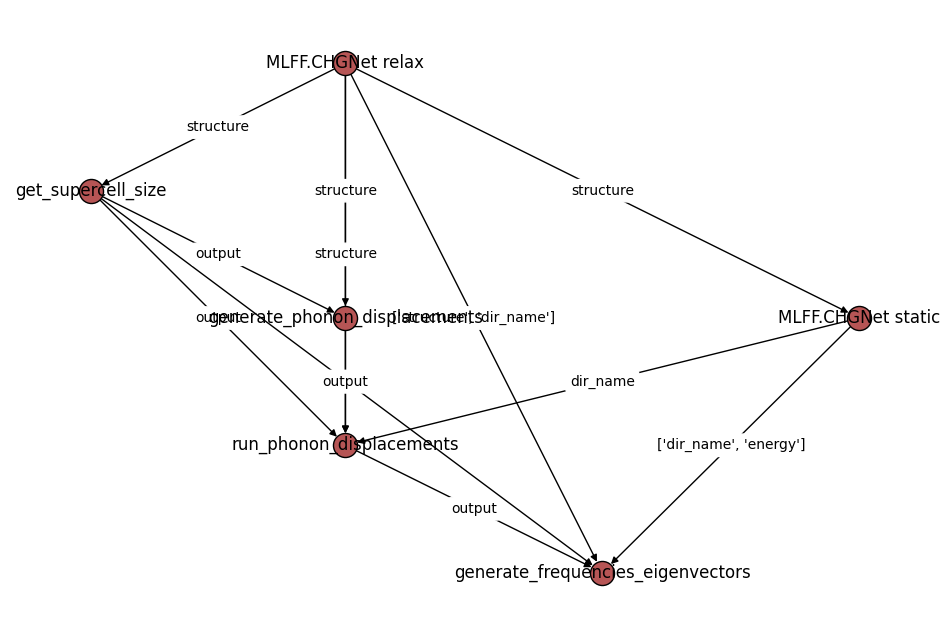

In [ ]:
phonon_flow.draw_graph().show()

In [ ]:
%%capture
run_locally(phonon_flow, create_folders=True)

INFO:jobflow.managers.local:Started executing jobs locally
INFO:jobflow.core.job:Starting job - MLFF.CHGNet relax (6acaa59a-102f-4de4-90d5-5e5ce8bb4a02)
INFO:jobflow.core.job:Finished job - MLFF.CHGNet relax (6acaa59a-102f-4de4-90d5-5e5ce8bb4a02)
INFO:jobflow.core.job:Starting job - get_supercell_size (26bb6198-07ff-4728-8381-4a8aa42e40e9)
INFO:jobflow.core.job:Finished job - get_supercell_size (26bb6198-07ff-4728-8381-4a8aa42e40e9)
INFO:jobflow.core.job:Starting job - MLFF.CHGNet static (434e3891-70ea-4e12-9f9e-81d26a9a1823)
INFO:jobflow.core.job:Finished job - MLFF.CHGNet static (434e3891-70ea-4e12-9f9e-81d26a9a1823)
INFO:jobflow.core.job:Starting job - generate_phonon_displacements (2cdf678c-f5b8-479f-8f95-3e6c75ed3d75)
INFO:jobflow.core.job:Finished job - generate_phonon_displacements (2cdf678c-f5b8-479f-8f95-3e6c75ed3d75)
INFO:jobflow.core.job:Starting job - run_phonon_displacements (a2ef0305-9180-4440-a504-15b2cb0e1caa)
INFO:jobflow.core.job:Finished job - run_phonon_displacement

In [ ]:
store = JFSet.JOB_STORE
store.connect()
result = store.query_one(
    {"name": "generate_frequencies_eigenvectors"},
    properties=[
        "output.phonon_dos",
        "output.phonon_bandstructure",
        ],
    load=True,
    sort={"completed_at": -1} # to get the latest computation
    )

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{Frequencies\\ (THz)}$'>

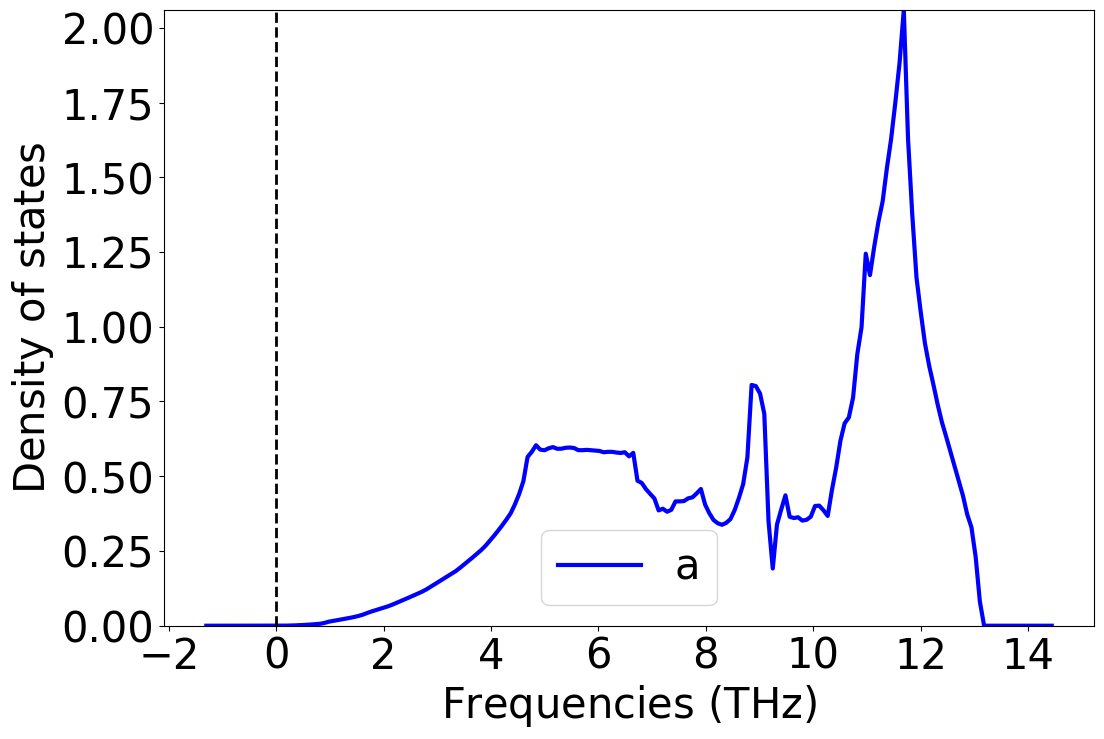

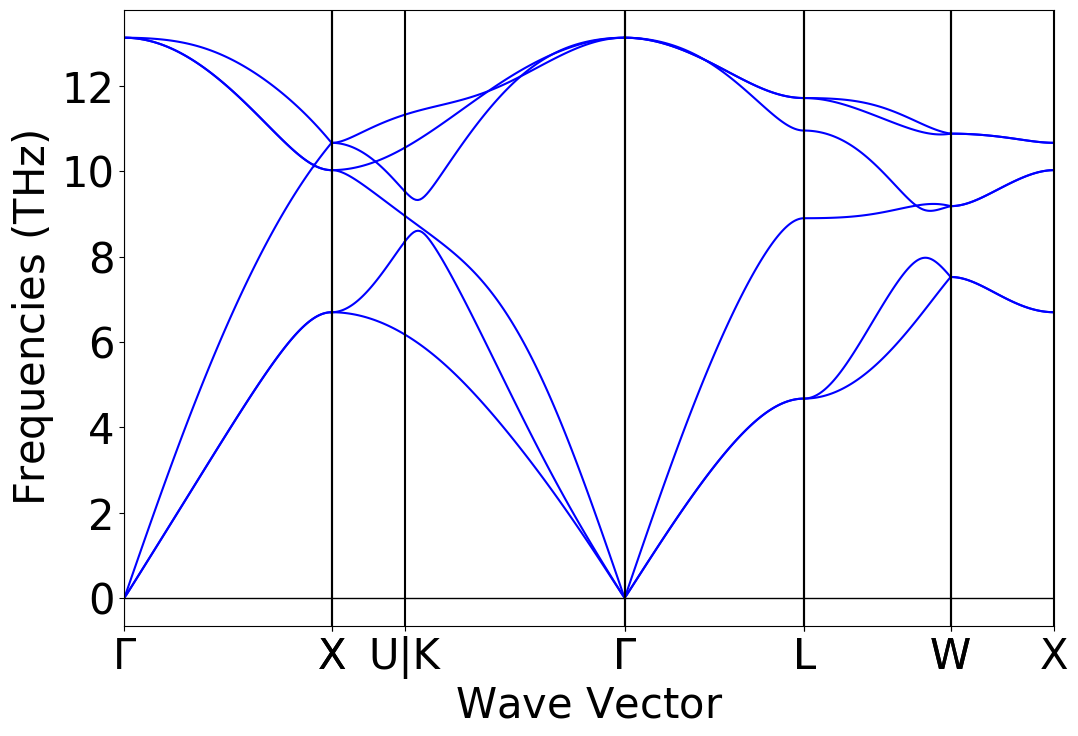

In [ ]:
ph_bs = PhononBandStructureSymmLine.from_dict(result['output']['phonon_bandstructure']) # get pymatgen bandstructure object
ph_dos = PhononDos.from_dict(result['output']['phonon_dos']) # get pymatgen phonon dos object
dos_plot = PhononDosPlotter()
dos_plot.add_dos(label='a', dos=ph_dos)
dos_plot.get_plot()
bs_plot = PhononBSPlotter(bs=ph_bs)
bs_plot.get_plot()

In [ ]:
struct = Structure(
    lattice=[[0, 2.73, 2.73], [2.73, 0, 2.73], [2.73, 2.73, 0]],
    species=["Si", "Si"],
    coords=[[0, 0, 0], [0.25, 0.25, 0.25]],
    )
phonon_flow = PhononMaker(min_length=15.0, store_force_constants=False,
                          bulk_relax_maker=M3GNetRelaxMaker(relax_kwargs={"fmax": 0.00001}),
                          phonon_displacement_maker=M3GNetStaticMaker(),
                          static_energy_maker=None).make(structure=struct)

In [ ]:
%%capture
run_locally(phonon_flow, create_folders=True, store=JFSet.JOB_STORE)

INFO:jobflow.managers.local:Started executing jobs locally
INFO:jobflow.core.job:Starting job - MLFF.M3GNet relax (9a6d8309-ff19-4d05-8355-6b283d621635)
INFO:jobflow.core.job:Finished job - MLFF.M3GNet relax (9a6d8309-ff19-4d05-8355-6b283d621635)
INFO:jobflow.core.job:Starting job - get_supercell_size (6edfbeb3-47f9-45a4-bd53-00e2d0180ba7)
INFO:jobflow.core.job:Finished job - get_supercell_size (6edfbeb3-47f9-45a4-bd53-00e2d0180ba7)
INFO:jobflow.core.job:Starting job - generate_phonon_displacements (f6200e2f-f760-42bb-95be-bdf0995b305b)
INFO:jobflow.core.job:Finished job - generate_phonon_displacements (f6200e2f-f760-42bb-95be-bdf0995b305b)
INFO:jobflow.core.job:Starting job - run_phonon_displacements (3d705366-8a1e-4534-867e-d6daacb87421)
INFO:jobflow.core.job:Finished job - run_phonon_displacements (3d705366-8a1e-4534-867e-d6daacb87421)
INFO:jobflow.core.job:Starting job - MLFF.M3GNet static 1/1 (fe15d354-3d6d-4f59-a8d6-1652ce492f4c)
INFO:jobflow.core.job:Finished job - MLFF.M3GNet s

In [ ]:
store = JFSet.JOB_STORE
store.connect()
result = store.query_one(
    {"name": "generate_frequencies_eigenvectors"},
    properties=[
        "output.phonon_dos",
        "output.phonon_bandstructure",
        ],
    load=True,
    sort={"completed_at": -1} # to get the latest computation
    )

ph_bs = PhononBandStructureSymmLine.from_dict(
    result['output']['phonon_bandstructure'])  # get pymatgen bandstructure object
ph_dos = PhononDos.from_dict(result['output']['phonon_dos'])  # get pymatgen phonon dos object

<Axes: xlabel='$\\mathrm{Frequencies\\ (THz)}$', ylabel='$\\mathrm{Density\\ of\\ states}$'>

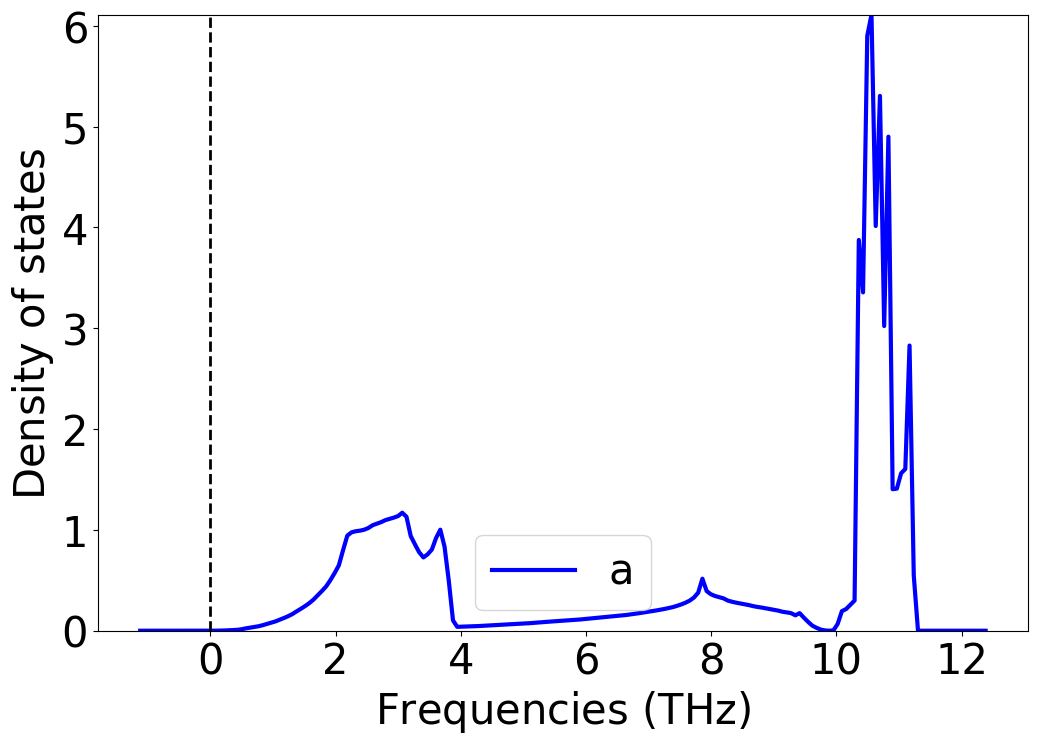

In [ ]:
dos_plot = PhononDosPlotter()
dos_plot.add_dos(label='a', dos=ph_dos)
dos_plot.get_plot()

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{Frequencies\\ (THz)}$'>

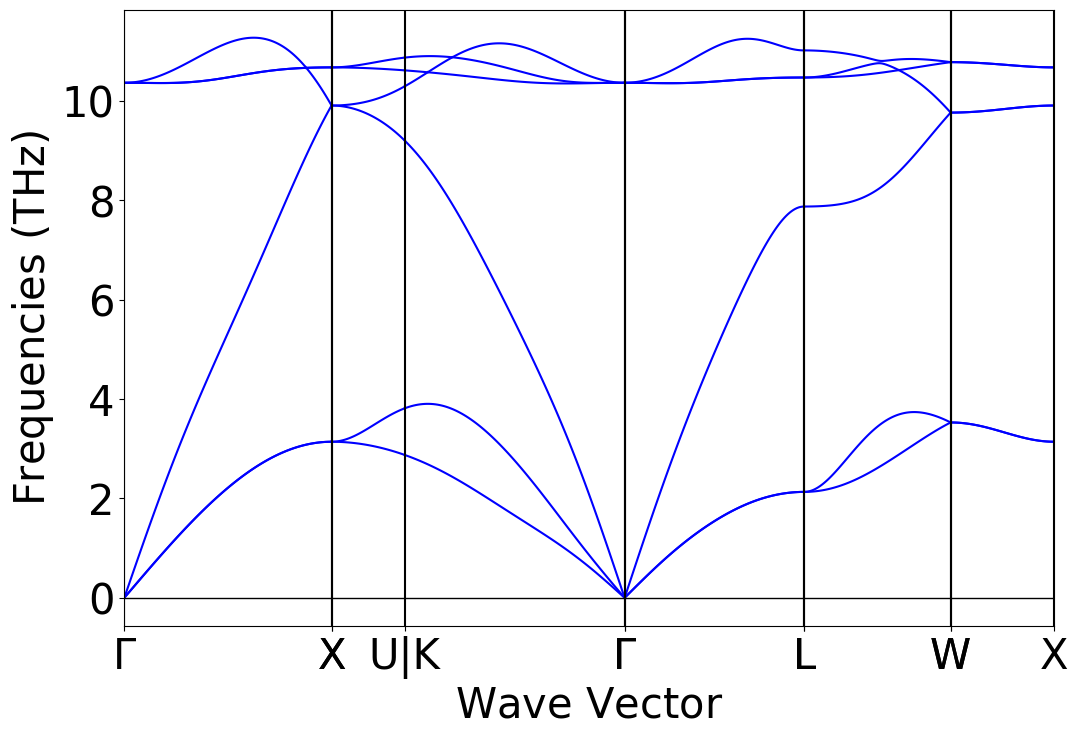

In [ ]:
bs_plot = PhononBSPlotter(bs=ph_bs)
bs_plot.get_plot()

# Elastic

In [ ]:
structure = Structure(
    lattice=[[0, 2.73, 2.73], [2.73, 0, 2.73], [2.73, 2.73, 0]],
    species=["Si", "Si"],
    coords=[[0, 0, 0], [0.25, 0.25, 0.25]],
    )
structure= SpacegroupAnalyzer(structure).get_primitive_standard_structure()
elastic_flow = ElasticMaker(
    bulk_relax_maker=M3GNetRelaxMaker(
        relax_cell=True, relax_kwargs={"fmax": 0.00001}
        ),
    elastic_relax_maker=M3GNetRelaxMaker(
        relax_cell=False, relax_kwargs={"fmax": 0.00001}
        ),
    ).make(structure)

In [ ]:
# elastic_flow.draw_graph().show()

In [ ]:
responses = run_locally(elastic_flow,  create_folders=True)

2024-04-02 18:12:00,951 INFO Started executing jobs locally


INFO:jobflow.managers.local:Started executing jobs locally


2024-04-02 18:12:00,963 INFO Starting job - MLFF.M3GNet relax (a28e4089-2655-4786-b98e-632e136cc978)


INFO:jobflow.core.job:Starting job - MLFF.M3GNet relax (a28e4089-2655-4786-b98e-632e136cc978)


2024-04-02 18:12:04,781 INFO Finished job - MLFF.M3GNet relax (a28e4089-2655-4786-b98e-632e136cc978)


INFO:jobflow.core.job:Finished job - MLFF.M3GNet relax (a28e4089-2655-4786-b98e-632e136cc978)


2024-04-02 18:12:04,799 INFO Starting job - generate_elastic_deformations (27f5f2f1-2646-4f5d-86eb-3ada76edf8d8)


INFO:jobflow.core.job:Starting job - generate_elastic_deformations (27f5f2f1-2646-4f5d-86eb-3ada76edf8d8)


2024-04-02 18:12:06,133 INFO Finished job - generate_elastic_deformations (27f5f2f1-2646-4f5d-86eb-3ada76edf8d8)


INFO:jobflow.core.job:Finished job - generate_elastic_deformations (27f5f2f1-2646-4f5d-86eb-3ada76edf8d8)


2024-04-02 18:12:06,148 INFO Starting job - run_elastic_deformations (fcfc4e0d-31f2-40c7-8d75-4239bda6edbd)


INFO:jobflow.core.job:Starting job - run_elastic_deformations (fcfc4e0d-31f2-40c7-8d75-4239bda6edbd)


2024-04-02 18:12:06,498 INFO Finished job - run_elastic_deformations (fcfc4e0d-31f2-40c7-8d75-4239bda6edbd)


INFO:jobflow.core.job:Finished job - run_elastic_deformations (fcfc4e0d-31f2-40c7-8d75-4239bda6edbd)


2024-04-02 18:12:06,528 INFO Starting job - MLFF.M3GNet relax 1/6 (22a2e629-9f5e-465f-bc4a-25cb42e91792)


INFO:jobflow.core.job:Starting job - MLFF.M3GNet relax 1/6 (22a2e629-9f5e-465f-bc4a-25cb42e91792)


2024-04-02 18:12:06,803 INFO Finished job - MLFF.M3GNet relax 1/6 (22a2e629-9f5e-465f-bc4a-25cb42e91792)


INFO:jobflow.core.job:Finished job - MLFF.M3GNet relax 1/6 (22a2e629-9f5e-465f-bc4a-25cb42e91792)


2024-04-02 18:12:06,823 INFO Starting job - MLFF.M3GNet relax 2/6 (81b5d19f-789f-4e51-a4f7-39bbb0471ef2)


INFO:jobflow.core.job:Starting job - MLFF.M3GNet relax 2/6 (81b5d19f-789f-4e51-a4f7-39bbb0471ef2)


2024-04-02 18:12:07,072 INFO Finished job - MLFF.M3GNet relax 2/6 (81b5d19f-789f-4e51-a4f7-39bbb0471ef2)


INFO:jobflow.core.job:Finished job - MLFF.M3GNet relax 2/6 (81b5d19f-789f-4e51-a4f7-39bbb0471ef2)


2024-04-02 18:12:07,084 INFO Starting job - MLFF.M3GNet relax 3/6 (b9894e25-cd01-43eb-a8b1-2a5b06bfc3c4)


INFO:jobflow.core.job:Starting job - MLFF.M3GNet relax 3/6 (b9894e25-cd01-43eb-a8b1-2a5b06bfc3c4)


2024-04-02 18:12:07,355 INFO Finished job - MLFF.M3GNet relax 3/6 (b9894e25-cd01-43eb-a8b1-2a5b06bfc3c4)


INFO:jobflow.core.job:Finished job - MLFF.M3GNet relax 3/6 (b9894e25-cd01-43eb-a8b1-2a5b06bfc3c4)


2024-04-02 18:12:07,369 INFO Starting job - MLFF.M3GNet relax 4/6 (9192407e-e491-43ae-8a4a-9e5454f391e6)


INFO:jobflow.core.job:Starting job - MLFF.M3GNet relax 4/6 (9192407e-e491-43ae-8a4a-9e5454f391e6)


2024-04-02 18:12:07,670 INFO Finished job - MLFF.M3GNet relax 4/6 (9192407e-e491-43ae-8a4a-9e5454f391e6)


INFO:jobflow.core.job:Finished job - MLFF.M3GNet relax 4/6 (9192407e-e491-43ae-8a4a-9e5454f391e6)


2024-04-02 18:12:07,686 INFO Starting job - MLFF.M3GNet relax 5/6 (8d9a8635-89a5-476f-ac66-c4b2b86be14a)


INFO:jobflow.core.job:Starting job - MLFF.M3GNet relax 5/6 (8d9a8635-89a5-476f-ac66-c4b2b86be14a)


2024-04-02 18:12:10,434 INFO Finished job - MLFF.M3GNet relax 5/6 (8d9a8635-89a5-476f-ac66-c4b2b86be14a)


INFO:jobflow.core.job:Finished job - MLFF.M3GNet relax 5/6 (8d9a8635-89a5-476f-ac66-c4b2b86be14a)


2024-04-02 18:12:10,446 INFO Starting job - MLFF.M3GNet relax 6/6 (c7a9c7a0-05a0-4651-b9d4-208c41f1724e)


INFO:jobflow.core.job:Starting job - MLFF.M3GNet relax 6/6 (c7a9c7a0-05a0-4651-b9d4-208c41f1724e)


2024-04-02 18:12:12,083 INFO Finished job - MLFF.M3GNet relax 6/6 (c7a9c7a0-05a0-4651-b9d4-208c41f1724e)


INFO:jobflow.core.job:Finished job - MLFF.M3GNet relax 6/6 (c7a9c7a0-05a0-4651-b9d4-208c41f1724e)


2024-04-02 18:12:12,098 INFO Starting job - store_inputs (fcfc4e0d-31f2-40c7-8d75-4239bda6edbd, 2)


INFO:jobflow.core.job:Starting job - store_inputs (fcfc4e0d-31f2-40c7-8d75-4239bda6edbd, 2)


2024-04-02 18:12:12,110 INFO Finished job - store_inputs (fcfc4e0d-31f2-40c7-8d75-4239bda6edbd, 2)


INFO:jobflow.core.job:Finished job - store_inputs (fcfc4e0d-31f2-40c7-8d75-4239bda6edbd, 2)


2024-04-02 18:12:12,121 INFO Starting job - fit_elastic_tensor (888ab72b-d790-4d8a-8d5b-81e1cd52002a)


INFO:jobflow.core.job:Starting job - fit_elastic_tensor (888ab72b-d790-4d8a-8d5b-81e1cd52002a)


2024-04-02 18:12:13,076 INFO Finished job - fit_elastic_tensor (888ab72b-d790-4d8a-8d5b-81e1cd52002a)


INFO:jobflow.core.job:Finished job - fit_elastic_tensor (888ab72b-d790-4d8a-8d5b-81e1cd52002a)


2024-04-02 18:12:13,095 INFO Finished executing jobs locally


INFO:jobflow.managers.local:Finished executing jobs locally


In [ ]:
store = JFSet.JOB_STORE
store.connect()
result = store.query_one(
    {"name": "fit_elastic_tensor"},
    properties=[
        "output.elastic_tensor",
        "output.derived_properties",
        ],
    load=True,
    sort={"completed_at": -1} # to get the latest computation
    )

In [ ]:
print(result["output"]["elastic_tensor"]["ieee_format"])

[[-14947.216835237865, 80.13047875910887, 80.13052437787397, -2.76583262387022e-05, -7.21405306303102e-05, 3.0049381220303704e-05], [80.13047875910888, -14947.192911777216, 80.13046025665534, -3.8582815190816994e-05, -5.1714289621303814e-05, -0.004018173007223767], [80.13052437787398, 80.13046025665534, -14947.209932769807, 0.0051592664573979485, 0.009646572565591949, 2.153770859891377e-05], [-2.7658326238698442e-05, -3.858281519081522e-05, 0.00515926645739795, 15.825024462918872, 4.250826073841568e-06, -1.021310201757925e-05], [-7.214053063031258e-05, -5.1714289621304376e-05, 0.009646572565591949, 4.250826073841486e-06, 15.825037122699207, -5.4622790748180385e-06], [3.0049381220303056e-05, -0.004018173007223769, 2.1537708598913186e-05, -1.0213102017579179e-05, -5.462279074818057e-06, 15.82502811754451]]


In [ ]:
print(result["output"]["derived_properties"])

{'k_voigt': -4928.981861444179, 'k_reuss': -4928.981862371242, 'k_vrh': -4928.9818619077105, 'g_voigt': -2995.9723916046028, 'g_reuss': 26.412135393475516, 'g_vrh': -1484.7801281055636, 'universal_anisotropy': -572.1583056373547, 'homogeneous_poisson': 0.3631263683196453, 'y_mod': -4047885887555.4287, 'trans_v': None, 'long_v': None, 'snyder_ac': None, 'snyder_opt': None, 'snyder_total': None, 'clark_thermalcond': None, 'cahill_thermalcond': None, 'debye_temperature': None}
